# Behavior Preprocessing

# Create Group Tidy DataFrame

The raw data gives us a separate dataframe per subject per modality. Ideally, we'd like to have a single group tidy dataframe to make visualizing and analyzing the group behavior easier. The cell below takes every individual subject dataframe and concatenates them into a single group dataframe where every row is a separate trial. The multilevel hierarchy of the data (subject > modality > trial) is accessible with participant_id and modality columns added to the dataframe. 

In addition to creating the group dataframe, the code first cleans up each individual subject's dataframe and extracts useful derived quantities.

In [ ]:
import sys
sys.path.append('../src')
from utils import select_subjects
from behavior import create_tidy_subject_df
import pandas as pd
import os

group_tidy_df = []
beh_f_stem = '../data/%s/%s/%s_task-msit_events.tsv'

# iterate through the two modalities
for modality in ['eeg', 'fmri']:
    
    subjects = select_subjects(modality, exclude=[])
    
    # replace with fmri with func for bids filename extraction
    if modality == 'fmri':
        stem_mod = 'func'
    else:
        stem_mod = 'eeg'
    
    # Iterate through each subject's dataframe, tidy, and concatenate 
    for subject in subjects:
        
        filename = beh_f_stem % (subject, stem_mod, subject)
        subject_tidy_df = create_tidy_subject_df(filename, subject, modality)

        group_tidy_df.append(subject_tidy_df)
        
# concatenate into single group tidy dataframe
group_tidy_df = pd.concat(group_tidy_df)

# select out and re-order columns, order rows
group_tidy_df = group_tidy_df[['participant_id', 'modality', 'trial', 
                               'onset', 'duration', 'iti', 'trial_type', 
                               'response_time', 'chosen_response', 
                               'correct_response', 'response_accuracy', 
                               'stimulus', 'error', 'post_error', 
                               'no_response', 'trial_type_sequence', 
                               'fast_rt']]
group_tidy_df = group_tidy_df.sort_values(by=['participant_id',
                                              'modality',
                                              'trial'])
# Save out to derivatives folder 
deriv_dir = '../data/derivatives/behavior'
if not os.path.exists(deriv_dir):
    os.makedirs(deriv_dir)
group_tidy_df.to_csv('%s/group_data.tsv' % deriv_dir, sep='\t',
                     index=False, na_rep='n/a')

group_tidy_df.head()

# Validate Task Design

## Check Task Design Consistency

First, we check for consistency in the task design across subjects. This was a complicated project that involved a lot of data collection across a long period of time. Thus, we want to make sure that every subject got the same version of the MSIT task. The cell below checks this by comparing every subject's task design dataframes to one another.

In [2]:
import pandas as pd

df = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                      sep='\t', na_values='n/a')

# filter to columns corresponding to task design that should 
# be identical
columns = ['duration', 'iti', 'stimulus', 'correct_response', 
           'trial_type_sequence']

for modality in ['eeg', 'fmri']:

    # filter to given modality
    mod_df = df[df.modality == modality]
    
    # iterate through all participant dataframes checking that they are
    # equivalent to first participant's dataframe (and thus to each other)
    mod_subjects = mod_df.participant_id.unique()
    ref_df = mod_df[mod_df.participant_id == mod_subjects[0]]
    ref_df = ref_df[columns].reset_index(drop=True)
    for i in range(1, len(mod_subjects)):
        check_df = mod_df[mod_df.participant_id == mod_subjects[i]]
        check_df = ref_df[columns].reset_index(drop=True)
        pd.testing.assert_frame_equal(ref_df, check_df)

We see no output... which is good! This means our assertion that all of the participant task design dataframes within each modality were equal did not fail. All participants received the same design as intended. 

### Verify Task Design Parameters 

In the next series of cells, we will extract and verify a set of important parameters regarding our task design. We'll also reveal any differences between the EEG and fMRI design as well. Since we've already verified that our task design is identical across subjects, we'll select out only the first subject's dataframe and analyze their task design information knowing that it is equivalent for all other subjects.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='whitegrid', font_scale=1.5)

df = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                 sep='\t', na_values='n/a')
df = df[df.participant_id == 'sub-hc001']

#### Trial Counts

The main contrast of interest is incongruent vs. congruent trials so let's see the trial counts:

In [4]:
df.groupby(['modality', 'trial_type']).onset.count()

modality  trial_type 
eeg       congruent      96
          incongruent    96
fmri      congruent      96
          incongruent    96
Name: onset, dtype: int64

Researchers have also traditionally looked at the effect of the previous trial type as a proxy for the effect of "conflict adaptation". For example, one would expect a person to be better at resolving an incongruent if they had more recently had to resolve such a trial.

In [5]:
df.groupby(['modality', 'trial_type_sequence']).onset.count()

modality  trial_type_sequence
eeg       cc                     47
          ci                     48
          ic                     49
          ii                     47
fmri      cc                     48
          ci                     47
          ic                     48
          ii                     48
Name: onset, dtype: int64

Interestingly, we don't quite have a balance in the eeg design (one more ic than there should be). Since we have an even number of trials there are an odd number of sequences and thus we can't have a perfect balance as one condition must have one less.

#### Trial Sequences

To develop some intution about the full trial sequences, let's plot a smoothed version of the condition sequences. 

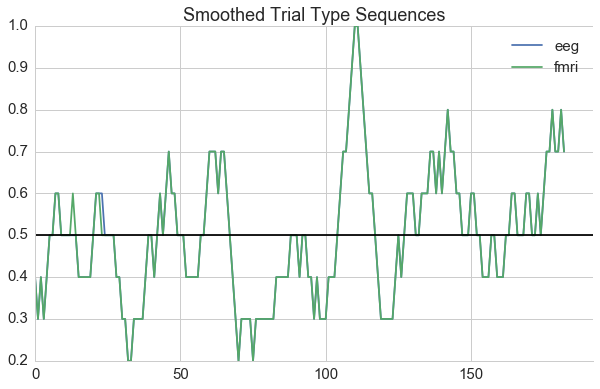

In [6]:
plt.figure(figsize=(10, 6))

modalities = ['eeg', 'fmri']
for i, modality in enumerate(modalities):
    mod_df = df[df.modality == modality]
    trial_types = mod_df.trial_type.astype('category').cat.codes
    plt.plot(np.convolve(trial_types, np.ones((10,))/10, mode='valid'))
    
plt.legend(modalities)
plt.axhline(0.5, color='k')
plt.title('Smoothed Trial Type Sequences')
plt.xlim((0, len(trial_types)))

sns.despine()
plt.show();

The time series above are smoothed with a moving average of every 10 timepoints. This allows us to get a sense of how the relative fractions of congruent vs. incongruent trials change throughout the experiment. The relative fraction is typically fairly centered around 0.5 (the mean is 0.5 since we do have an equal fraction across the entire experiment) with the exception of a particularly strong incongruent bias around 100 trials in. Note that there is a bit of a congruent bias in the first half of the experiment and then a more incongruent bias in the second half of the experiment, but it is relatively minor.

One interesting peculiarity is that the eeg and fmri trial sequences appear to be identical with the exception of a difference somewhere around trial 25. I would have expected them to be more different given that the n-1 sequence counts were different, but it looks as if those n-1 trial sequence count differences may have been due to a single shift. Let's investigate.

In [7]:
eeg = df[df.modality == 'eeg'].trial_type.astype('category').cat.codes
fmri = df[df.modality == 'fmri'].trial_type.astype('category').cat.codes
print(np.where(np.abs(np.array(eeg) - np.array(fmri)) > 0))
print(eeg[20:25])
print(fmri[20:25])

(array([22, 23]),)
20    0
21    1
22    0
23    1
24    0
dtype: int8
212    0
213    1
214    1
215    0
216    0
dtype: int8


Very peculiar. Trials 23 and 24 are swapped between the eeg and fmri versions. I have no idea why the trial sequences would be different like this. I would either expect them to be completely different or exactly identical. In any case, we can conclude that the trial sequences are effectively identical though there is this one small difference.

#### Trial Timing

First, let's see what the total run time of our tasks was:

In [8]:
def time_column(seq):
    total = seq.sum()
    m, s = total // 60, total % 60
    return '%d min %d sec' % (m, s)

df['trial_time'] = df['duration'] + df['iti']
df.groupby(['modality'])['trial_time'].apply(time_column)

modality
eeg     11 min 59 sec
fmri     6 min 37 sec
Name: trial_time, dtype: object

So we see that the eeg version is almost twice as long. Since they have the same trial counts, this must stem from timing differences. We check the response windows.

In [9]:
df.groupby(['modality', 'duration']).duration.count()

modality  duration
eeg       1.75        192
fmri      1.75        192
Name: duration, dtype: int64

So every response was limited to 1.75 seconds. This isn't the difference since the task did not advance on a response being made. The difference must stem from the inter-trial interval differences so let's take a look at those:

In [12]:
df.groupby(['modality', 'iti']).iti.count()

modality  iti 
eeg       1.75     64
          2.00     65
          2.25     63
fmri      0.00    162
          1.75     26
          3.50      3
          5.25      1
Name: iti, dtype: int64

So we see that the EEG design has an ITI distribution ~ U([1.75, 2, 2.25]). It is important that the ITI is not purely constant as this variation (often referred to as jitter) prevents predicting the upcoming trial onset which can affect the baseline period of the eeg signal. For the fmri, we see that the majority of the differences are 0 with some out at 1.75, 3.5 and 5.25 in decreasing amounts. I'm not entirely sure on the basis of this ITI distribution, but supposedly it was determined by optseq to provide an optimal design given the trial design and trial counts. We can clearly see that the difference in timing comes from the fmri iti's being predominantly 0.

# Subject Exclusions

### Visualize Exclusion Metrics

Here we will check some measures to determine if any subject's data should be excluded based on 3 different factors:

- Non-reponses: Non-responses can imply that a person struggled with a trial and wasn't able to respond in time. Or more problematically, they can imply a lack of engagement with the task (in the worst case, they may even be dozing off). An excessive non-response rate may suggest grounds for exclusion since it signals severe disengagement and/or that the response timeout was too fast for that participant.
- Errors: While errors in and of themselves aren't bad and suggest the task has some difficulty to it, excessive errors could imply an inability to understand the task. In the extreme case, they could also signal indiscriminate responding or a misunderstanding of the task rules.
- Fast Responses: Large amounts of fast responses (defined here as less than 200 ms) could imply that the subject was again indiscriminately responding since responses at this speed are too fast to have resolved the correct response. 

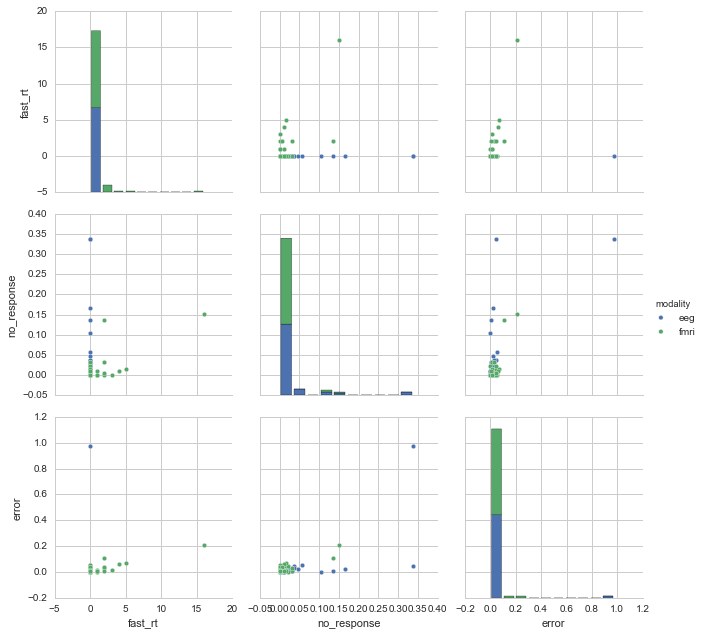

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

df = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                      sep='\t', na_values='n/a')

agg_df = df[['participant_id', 'modality', 'error', 'no_response', 
                  'fast_rt']] \
             .groupby(['participant_id', 'modality'], as_index=False) \
             .agg({'error': 'mean', 'no_response': 'mean',
                   'fast_rt': 'sum'}) 
        
sns.pairplot(agg_df, hue='modality', size=3, aspect=1)
plt.show()

A few outliers immediately jump out:
- We have an eeg participant who had nearly a 100 percent error rate on top of a 30 percent missing rate who we will definitely need to exclude. I'm not exactly sure how they had such a high error rate. Even random responding would be expected to result in a lower error rate. On top of that, they did the task without an excessive error rate in the fmri prior to the eeg version. Even if they were responding according to an incorrect rule (i.e. location instead of identity), I still wouldn't expect the error rate to be that high. 
- We have a fmri participant who had a fairly large error rate (~20%) and a large number of fast responses and fairly large non_reponse rate. This is again suggestive of someone who was not engaged. They were responding too quickly to be able to evaluate the response frequently, they were getting a lot of trials wrong (probably a lot due to the fast responses), and they didn't engage with 10-20% of the trials. Probably grounds for exclusion.
- There is another individual who didn't respond on greater than 30% of trials. Though they didn't have a particularly large error rate, this is still a significant percentage of trials to not respond and probably grounds for exclusion.

Some comments on distributions:
- Fast responses: Apart from our outlier, our fast responses are very reasonable with the next highest value being around 5 or so and most being at 0.
- Error: Apart from two of our outliers, the vast majority of our the density lies around 0. While it is nice not to have too many excessive error rates, this also seems to hint that we may not have enough errors to be able to explore them as a dependent variable. We'll look more closely later.
- Non-Reponses: The vast majority of the density is clustered around 0. We have the two outliers out at around 30%. We also have a smaller cluster of individuals around 10-20% that we should be wary of.

### Subject Exclusions

Here we will actually denote subject exclusions. To avoid complete subjectivity, we'll use a more objective criterion for exclusion. Since all of our exclusion metrics above lead to data lost, we can collapse all of our metrics into a single metric: the number of non-excluded trials. We can then define a threshold for outliers along this metric. Here we'll use the following metric:

Exclude subject if number of trials after all exclusions < (median - 3 * mad) 

This is similar to z-scoring, but we use robust versions of the mean and standard deviation since we know our distribution will be skewed with some large outliers. The three is somewhat arbitrary and comes as a slightly more data keeping conservative threshold than the 2 standard deviations I've seen typically.

eeg
Threshold: 154 trials
Rejected Subjects:
   participant_id modality  fast_rt  no_response     error
24      sub-hc013      eeg        0     0.338542  0.976378
52      sub-hc027      eeg        0     0.338542  0.047244
fmri
Threshold: 173 trials
Rejected Subjects:
   participant_id modality  fast_rt  no_response     error
53      sub-hc027     fmri        2     0.135417  0.108434
75      sub-hc041     fmri       16     0.151042  0.208589


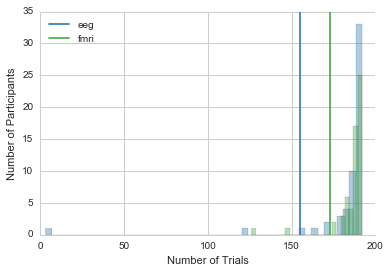

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='whitegrid')

df = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                 sep='\t', na_values='n/a')
exclusions = {}

# Create a new column that is 0 if a trial passes all 
# of our exclusion metrics
exclusion_columns = ['error', 'no_response', 'fast_rt']
df = df[['participant_id', 'modality'] + exclusion_columns]
df['exclude'] = df.sum(axis=1)

# Create a summary dataframe with non-excluded trial counts
trial_count_df = df[df.exclude == 0] \
                 .groupby(['participant_id', 'modality'],
                          as_index=False) \
                 .agg('count')
    
# Create a summary dataframe with exclusion metrics for each participant
# modality pairing
agg_df = df.groupby(['participant_id', 'modality'], as_index=False) \
                .agg({'error': 'mean', 'no_response': 'mean',
                      'fast_rt': 'sum'})
    

# Iterate through modalities
for col, mod in zip(['#377eb8', '#4daf4a'], ['eeg', 'fmri']):
    print(mod)
    
    exclusions[mod] =[] 
    
    # Subset our summary dataframes by modality
    trial_mod_df = trial_count_df[trial_count_df.modality == mod]
    agg_mod_df = agg_df[agg_df.modality == mod]
    
    # Calculate exclusion threshold
    threshold = trial_mod_df['error'].median() - \
                3 * trial_mod_df['error'].mad()
    print('Threshold: %d trials' % threshold)
    
    # Plot distribution of trials counts with threshold cutoff
    sns.distplot(trial_mod_df['error'], norm_hist=False, kde=False, 
                 color=col)
    plt.axvline(threshold, color=col, label='__no_legend')
    
    # Extract subject indices of excluded subjects by threshold
    sub_ix = np.where(trial_mod_df['error'] < threshold)[0]
    
    print('Rejected Subjects:')
        
    # show exclusion information
    sub = agg_mod_df.iloc[sub_ix, :]
    print(sub)
        
    # update our exclusions dictionary
    exclusions[mod] += list(sub.participant_id)
        
        
# Pretty plot and show
plt.xlabel('Number of Trials')
plt.ylabel('Number of Participants')
plt.legend(['eeg', 'fmri'], loc='best')
sns.despine()
plt.show()            

We've selected out the very worst offenders in the EEG. We've also picked out two bad subjects in the fmri who lost over a quarter of trials when taking fast responses, no_responses, and errors together. We write these exclusions out to file below.

In [ ]:
import sys
sys.path.append('../src')
from utils import exclude_subjects

exclude_subjects(exclusions['fmri'], 'behavior_fmri')
exclude_subjects(exclusions['eeg'], 'behavior_eeg')